In [1]:
from IPython.core.debugger import set_trace

%load_ext nb_black


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/MSFT/MSFT_WITH_BENZINGA_FINBERT_SA.csv"

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df = df[["5. adjusted close"]].copy()

<IPython.core.display.Javascript object>

In [4]:
split_time = int(len(df) * .9)

train_df = df[:split_time]
test_df = df[split_time:]

print(len(train_df))
print(len(test_df))

df = test_df[["5. adjusted close"]].copy()

2757
307


<IPython.core.display.Javascript object>

In [5]:
df.describe()

,5. adjusted close
count,307.000000
mean,276.163919
std,37.300208
min,210.051892
25%,242.339020
50%,282.417959
75%,302.217360
max,342.401190


<IPython.core.display.Javascript object>

In [6]:
df.head()

,5. adjusted close
2757,211.912422
2758,217.009088
2759,217.147638
2760,216.326234
2761,220.284809


<IPython.core.display.Javascript object>

### Check if the time series is stationary

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["5. adjusted close"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6999661731484106
p-value: 0.43112990556462827


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

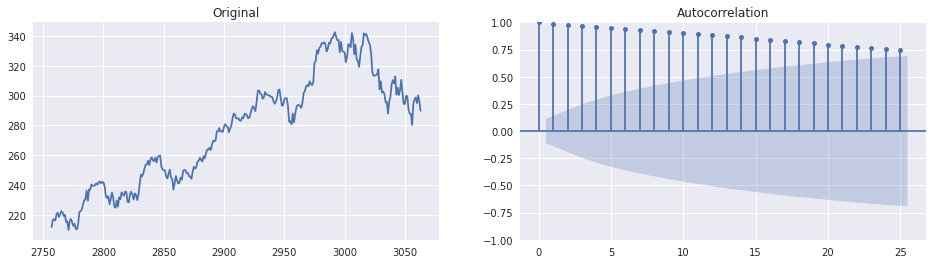

<IPython.core.display.Javascript object>

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df["5. adjusted close"])
ax1.set_title("Original")
plot_acf(df["5. adjusted close"], ax=ax2);

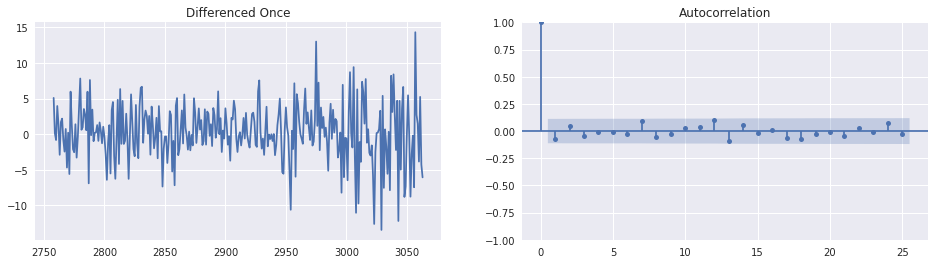

<IPython.core.display.Javascript object>

In [10]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

In [11]:
# pip install pmdarima
from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [12]:
ndiffs(df["5. adjusted close"])

1

<IPython.core.display.Javascript object>

__p__

p is the order of the Auto Regressive (AR) term.  It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


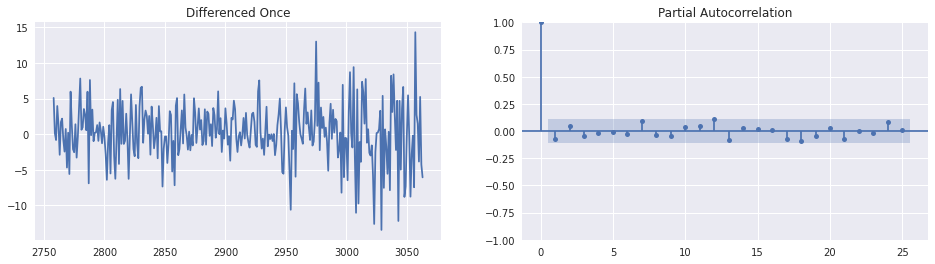

<IPython.core.display.Javascript object>

In [14]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_pacf(diff, ax=ax2);

__q__

q is the order of the Moving Average (MA) term.  It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.



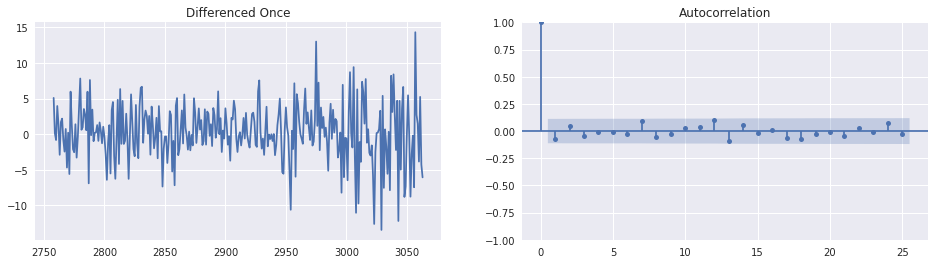

<IPython.core.display.Javascript object>

In [15]:
diff = df["5. adjusted close"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2);

#### Fitting the ARIMA Model

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df["5. adjusted close"], order=(12,1,13))
result = model.fit()


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      5. adjusted close   No. Observations:                  307
Model:               ARIMA(12, 1, 13)   Log Likelihood                -845.051
Date:                Sat, 09 Jul 2022   AIC                           1742.103
Time:                        05:02:06   BIC                           1838.916
Sample:                             0   HQIC                          1780.822
                                - 307                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6728      1.078     -0.624      0.532      -2.785       1.439
ar.L2          0.0926      1.027      0.090      0.928      -1.920       2.105
ar.L3         -0.0015      0.587     -0.003      0.998      -1.151       1.148
ar.L4         -0.1343      0.564     -0.238      0.812      -1.241       0.972
ar.L5          0.1011      0.503      0.201      0.841      -0.886       1.088
ar.L6          0.0368      0.554      0.066      0.947      -1.049       1.123
ar.L7         -0.1192      0.476     -0.250      0.802      -1.053       0.814
ar.L8          0.0845      0.593      0.142      0.887      -1.078       1.247
ar.L9         -0.0505      0.388     -0.130      0.896      -0.811       0.710
ar.L10        -0.4451      0.362     -1.228      0.219      -1.155       0.265
ar.L11        -0.4163      0.694     -0.600      0.548      -1.776       0.943
ar.L12        -0.3642      0.517     -0.704      0.482      -1.378       0.650
ma.L1          0.6115      1.210      0.505      0.613      -1.761       2.984
ma.L2         -0.0387      1.625     -0.024      0.981      -3.223       3.145
ma.L3          0.0512      1.304      0.039      0.969      -2.506       2.608
ma.L4          0.0385      0.965      0.040      0.968      -1.854       1.931
ma.L5         -0.2075      0.901     -0.230      0.818      -1.973       1.558
ma.L6         -0.0021      0.765     -0.003      0.998      -1.502       1.498
ma.L7          0.3154      1.094      0.288      0.773      -1.828       2.459
ma.L8         -0.0692      1.180     -0.059      0.953      -2.381       2.243
ma.L9         -0.0136      1.310     -0.010      0.992      -2.581       2.553
ma.L10         0.5003      1.130      0.443      0.658      -1.714       2.715
ma.L11         0.5702      1.353      0.421      0.673      -2.082       3.222
ma.L12         0.5267      0.941      0.560      0.576      -1.317       2.371
ma.L13        -0.0582      0.177     -0.329      0.742      -0.405       0.288
sigma2        14.3991     15.500      0.929      0.353     -15.981      44.779
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

In [18]:
# Actual vs. Fitted

# result.plot_diagnostics()
len(result.forecasts[0])

307

<IPython.core.display.Javascript object>

In [19]:
df["preds"] = result.forecasts[0]

<IPython.core.display.Javascript object>

In [20]:
df.head()

,5. adjusted close,preds
2757,211.912422,0.000000
2758,217.009088,211.912199
2759,217.147638,216.685390
2760,216.326234,217.454416
2761,220.284809,216.278558


<IPython.core.display.Javascript object>

In [21]:
result.forecasts[0][-306:]

array([211.91219933, 216.68539016, 217.45441588, 216.27855828,
       219.86531254, 221.81708913, 218.81531519, 220.66015789,
       222.43982673, 221.75820153, 220.02126568, 220.26783158,
       215.64367098, 215.29587837, 211.05640644, 215.72074372,
       217.19568138, 215.43319977, 212.51078943, 213.72809197,
       210.33517184, 210.68779289, 213.76296829, 221.0272006 ,
       222.79851137, 223.48731147, 227.18688813, 229.24125623,
       231.05068789, 236.98552615, 230.2536746 , 235.64170579,
       239.05463466, 241.55965951, 240.87191623, 239.32618132,
       239.07085936, 243.34071   , 240.64005902, 241.65184876,
       241.49797155, 240.86811002, 243.8236971 , 240.37816419,
       237.53829972, 232.40853083, 231.28757565, 232.80463172,
       227.19648994, 228.73324859, 236.53377475, 231.72157688,
       226.20407079, 224.17552707, 228.41635886, 228.66110648,
       231.58260156, 229.87035267, 233.81356214, 234.76612262,
       235.36770153, 233.88118502, 233.48769963, 230.08

<IPython.core.display.Javascript object>

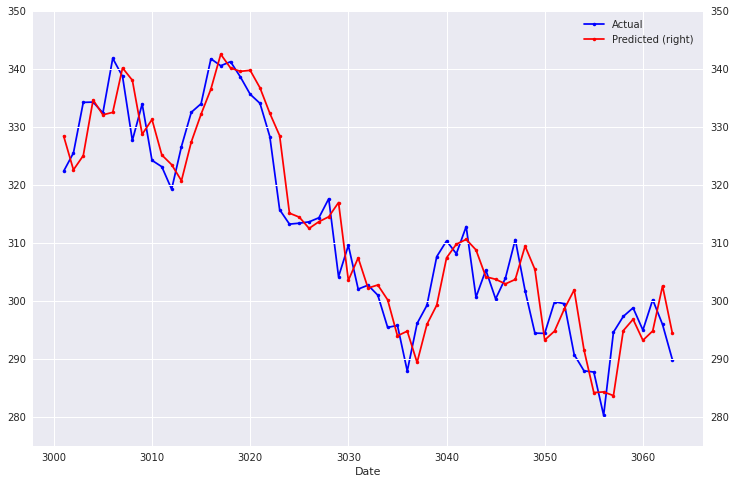

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(12,8))

ax1 = df["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')

a, b = 275, 350

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [23]:
true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))


print(mae(true, predicted))

3.016636646722445


<IPython.core.display.Javascript object>

In [24]:
df.tail()

,5. adjusted close,preds
3059,298.79,296.814574
3060,294.95,293.190758
3061,300.19,294.808744
3062,295.92,302.574684
3063,289.86,294.416050


<IPython.core.display.Javascript object>

In [25]:
df = df[-244:].copy()

true = df["5. adjusted close"][-244:]
predicted = df["preds"][-244:]

<IPython.core.display.Javascript object>

In [26]:
from sklearn.metrics import mean_absolute_error

<IPython.core.display.Javascript object>

In [27]:
test_mae = mean_absolute_error(true.to_numpy(), predicted)
f'Test MAE: {test_mae:.4f}'

'Test MAE: 3.0166'

<IPython.core.display.Javascript object>

In [28]:
df.head(10)

,5. adjusted close,preds
2820,228.854221,233.487700
2821,228.487213,230.083341
2822,234.081604,229.195928
2823,235.658746,233.837539
2824,233.555890,234.491442
2825,230.461120,234.617832
2826,234.567641,231.582711
2827,233.337669,233.420849
2828,229.975083,232.321394
2829,233.863383,231.422558


<IPython.core.display.Javascript object>

In [29]:
df["actual_percentage_change"] = df['5. adjusted close'].pct_change()
df["actual_increase"] = df["actual_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [30]:
df["predicted_percentage_change"] = df['preds'].pct_change()
df["predicted_increase"] = df["predicted_percentage_change"].apply(lambda x: 1 if x > 0 else 0)

<IPython.core.display.Javascript object>

In [31]:
df.head(10)

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
2820,228.854221,233.487700,NaN,0,NaN,0
2821,228.487213,230.083341,-0.001604,0,-0.014580,0
2822,234.081604,229.195928,0.024484,1,-0.003857,0
2823,235.658746,233.837539,0.006738,1,0.020252,1
2824,233.555890,234.491442,-0.008923,0,0.002796,1
2825,230.461120,234.617832,-0.013251,0,0.000539,1
2826,234.567641,231.582711,0.017819,1,-0.012936,0
2827,233.337669,233.420849,-0.005244,0,0.007937,1
2828,229.975083,232.321394,-0.014411,0,-0.004710,0
2829,233.863383,231.422558,0.016907,1,-0.003869,0


<IPython.core.display.Javascript object>

In [32]:
df.tail(10)

,5. adjusted close,preds,actual_percentage_change,actual_increase,predicted_percentage_change,predicted_increase
3054,287.93,291.539260,-0.009631,0,-0.034269,0
3055,287.72,284.183206,-0.000729,0,-0.025232,0
3056,280.27,284.291175,-0.025893,0,0.000380,1
3057,294.59,283.655120,0.051094,1,-0.002237,0
3058,297.31,294.857218,0.009233,1,0.039492,1
3059,298.79,296.814574,0.004978,1,0.006638,1
3060,294.95,293.190758,-0.012852,0,-0.012209,0
3061,300.19,294.808744,0.017766,1,0.005519,1
3062,295.92,302.574684,-0.014224,0,0.026342,1
3063,289.86,294.416050,-0.020479,0,-0.026964,0


<IPython.core.display.Javascript object>

In [33]:
df = df.drop(2820)

<IPython.core.display.Javascript object>

#### Postive Increase Prediction %

In [34]:
df[(df["actual_increase"]==1) & (df["predicted_increase"]==1)].shape[0] / df[(df["actual_increase"]==1)].shape[0]

0.6031746031746031

<IPython.core.display.Javascript object>

### Negative Increase Prediction %

In [36]:
df[(df["actual_increase"]==0) & (df["predicted_increase"]==0)].shape[0] / df[(df["actual_increase"]==0)].shape[0]

0.49572649572649574

<IPython.core.display.Javascript object>

#### Overall Prediction Accuracy %

In [37]:
df[(df["actual_increase"] == df["predicted_increase"])].shape[0] / (df.shape[0])

0.551440329218107

<IPython.core.display.Javascript object>

#### Actual Distribution of Increase (1) vs. Decrease (0)

In [38]:
df["actual_increase"].value_counts(normalize=True)

1    0.518519
0    0.481481
Name: actual_increase, dtype: float64

<IPython.core.display.Javascript object>